# TICL Pattern Recognition

This notebook builds a labeled dataset for identifying complete and incomplete tracksters.

In [1]:
import uproot

# double gamma (two photons)
file_name = "data/ntuples_13801550_969.root"

tracksters_ds    = {file_name: "ticlNtuplizer/tracksters"}
simtracksters_ds = {file_name: "ticlNtuplizer/simtrackstersSC"}
associations_ds  = {file_name: "ticlNtuplizer/associations"}

Load the datasets

In [2]:
tracksters = uproot.open(tracksters_ds)
simtracksters = uproot.open(simtracksters_ds)
associations = uproot.open(associations_ds)

Print the available attributes

In [3]:
tracksters.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
event                                    | uint32_t                 | AsDtype('>u4')
NClusters                                | uint32_t                 | AsDtype('>u4')
NTracksters                              | uint32_t                 | AsDtype('>u4')
time                                     | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
timeError                                | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
regressed_energy                         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_energy                               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_em_energy                            | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
raw_pt                                

In [4]:
simtracksters.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
stsSC_event                              | uint32_t                 | AsDtype('>u4')
stsSC_NClusters                          | uint32_t                 | AsDtype('>u4')
stsSC_NTracksters                        | uint32_t                 | AsDtype('>u4')
stsSC_time                               | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_timeError                          | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_regressed_energy                   | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_energy                         | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_em_energy                      | std::vector<float>       | AsJagged(AsDtype('>f4'), he...
stsSC_raw_pt                          

In [5]:
associations.show(name_width=40)

name                                     | typename                 | interpretation                
-----------------------------------------+--------------------------+-------------------------------
tsCLUE3D_recoToSim_SC                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_SC_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_SC                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_SC_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_SC_sharedE            | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_CP                    | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_recoToSim_CP_score              | std::vector<std::vect... | AsObjects(AsVector(True, As...
tsCLUE3D_simToReco_CP                    | std::vector<std::vect... | AsObjects(AsVector(Tr

In [6]:
# print some stats
print("Events:", tracksters["event"].array())
print("Rec Tracksters:", tracksters["NTracksters"].array())
print("Sim Tracksters:", simtracksters["stsSC_NTracksters"].array())

Events: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, ... 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]
Rec Tracksters: [2, 3, 2, 3, 5, 2, 3, 3, 5, 2, 3, 3, 4, 2, ... 2, 2, 2, 3, 2, 1, 2, 2, 2, 2, 2, 1, 2]
Sim Tracksters: [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ... 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


Plot the tracksters
- there is 100 events in the dataset

In [7]:
from plotting_utils import plot_event
%matplotlib inline

SimTracksters: 2
RecoTracksters: 3


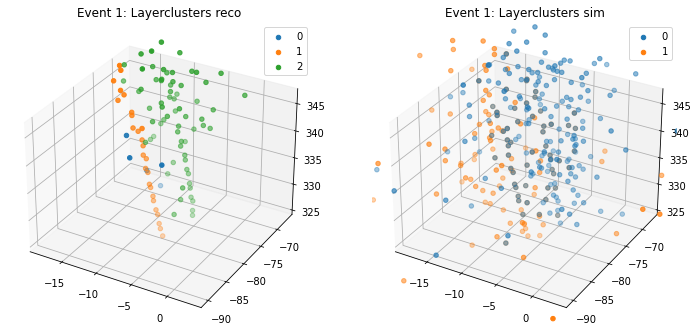

In [8]:
eid = 1
plot_event(tracksters, simtracksters, eid)
print("SimTracksters:", simtracksters["stsSC_NTracksters"].array()[eid])
print("RecoTracksters:", tracksters["NTracksters"].array()[eid])

### Association scores
- 1 means completely unmatched
- 0 means a perfect 

The idea is to use argmax over the scores and then get the index of the best matched trackster

In [9]:
r2si = associations["tsCLUE3D_recoToSim_SC"].array()[eid]
r2s = associations["tsCLUE3D_recoToSim_SC_score"].array()[eid] # [tracksters] -> [simtracksters]

s2ri = associations["tsCLUE3D_simToReco_SC"].array()[eid]
s2r = associations["tsCLUE3D_simToReco_SC_score"].array()[eid] # [simtracksters] -> [tracksters]

print("Reco to sim:", r2s)
print("Reco to sim indexes:", r2si)

print("Sim to reco:", s2r)
print("Sim to reco indexes:", s2ri)

Reco to sim: [[0.594, 0.124], [0.983, 0.000295], [0.985, 0.000688]]
Reco to sim indexes: [[1, 0], [0, 1], [1, 0]]
Sim to reco: [[0.00518, 1, 1], [0.00868, 0.998, 1]]
Sim to reco indexes: [[2, 0, 1], [1, 2, 0]]


### Training set categories:
- **perfect match**
    - same number of sim and reco tracksters
    - only one matched trackster below a threshold
- **mix-up** (skip for now)
    - same number of sim and reco tracksters
    - multiple matched tracksters below a threshold
    - should be split and reclustered?
- **overmerged** (skip for now)
    - more sim tracksters than reco tracksters
    - should be split
- **split**
    - more reco tracksters than sim tracksters
    - multiple well matched tracksters
    - should be joined

In [10]:
from matching_utils import split_on_shared_energy, get_eid_splits, unfold_tracksters

In [11]:
perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

Perfect events: [0, 2, 5, 9, 13, 14, 20, 24, 26, 27, 28, 29, 32, 33, 35, 37, 41, 43, 45, 47, 48, 50, 51, 54, 60, 64, 66, 69, 70, 73, 74, 77, 78, 80, 82, 83, 84, 87, 88, 89, 91, 93, 94, 95, 97, 99]
Split events: [1, 3, 4, 6, 7, 8, 10, 11, 12, 15, 16, 18, 23, 25, 30, 31, 34, 36, 38, 39, 42, 46, 49, 55, 56, 57, 58, 59, 61, 62, 63, 67, 68, 71, 72, 75, 79, 81, 85, 86, 90]


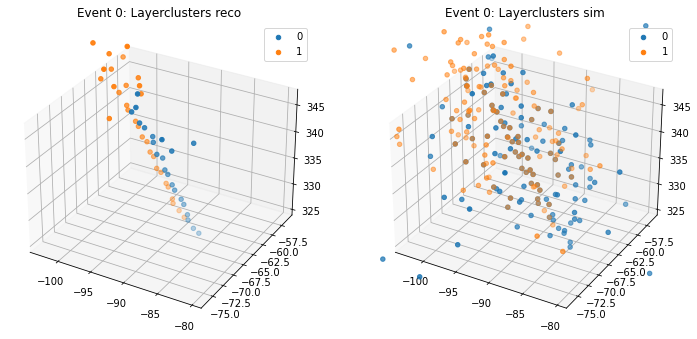

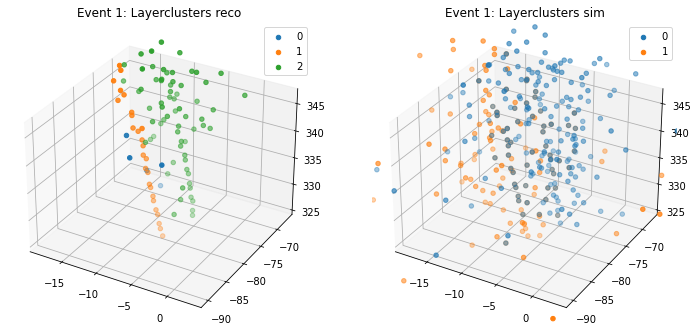

In [12]:
print("Perfect events:", perfect_eids)
print("Split events:", split_eids)

plot_event(tracksters, simtracksters, perfect_eids[0])
plot_event(tracksters, simtracksters, split_eids[0])

### Incomplete trackster identification

Not all tracksters in a split event are incomplete.
- Try to identify the most mismatched tracksters
- We even know how many they should be

Incomplete trackster candidates
- use fractions simToReco shared energy (fraction shared to total)
- tracksters with the smallest fraction are probably the ones we need to merge in
- TODO: get histograms of these fractions (to test the separation)

Total reco tracksters: 140, complete: 77, Incomplete: 58


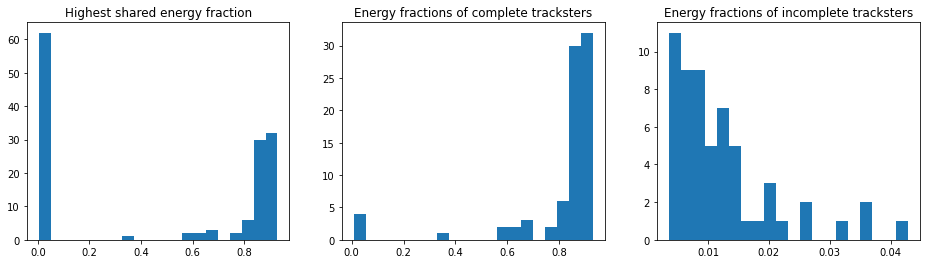

In [13]:
complete_tracksters, incomplete_tracksters = split_on_shared_energy(tracksters, simtracksters, associations, split_eids, histogram=True)

Observe the little blob on the left side of the histogram in the middle.

This means that some complete tracksters are overlapping with the incomplete tracksters.

### Inspect the results

Event 1: complete: [1, 2] incomplete : [0]
Event 3: complete: [0, 1] incomplete : [2]


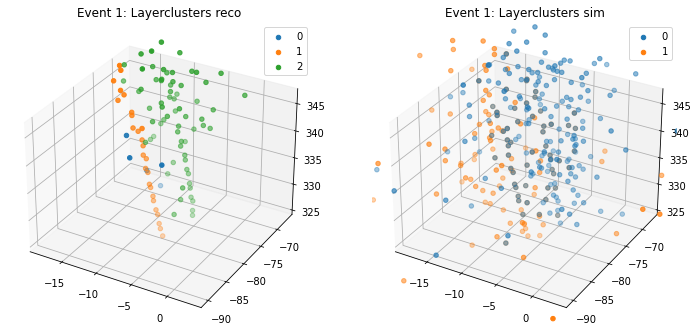

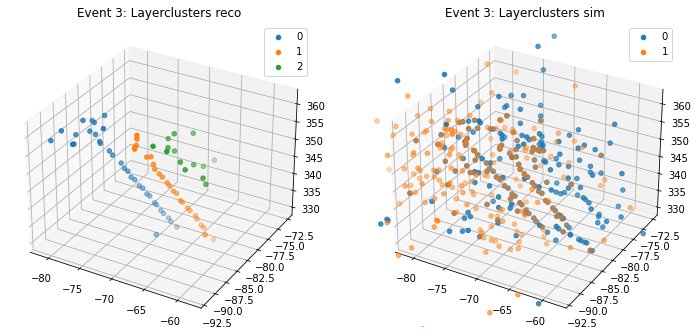

In [14]:
for i, (eid, it) in enumerate(incomplete_tracksters[:2]):
    print(f"Event {eid}: complete: {complete_tracksters[i][1]} incomplete : {it}")
    plot_event(tracksters, simtracksters, eid)

In [32]:
vertices_x = []
vertices_y = []
vertices_z = []
vertices_energy = []
vertices_indexes = []
trackster_label = []
trackster_event = []
# trackster_file = []

def get_event_data(eid):
    vx = tracksters["vertices_x"].array()[eid]
    vy = tracksters["vertices_y"].array()[eid]
    vz = tracksters["vertices_z"].array()[eid]
    ve = tracksters["vertices_energy"].array()[eid]
    vi = tracksters["vertices_indexes"].array()[eid]
    return vx, vy, vz, ve, vi

datafiles = [
    f"new_ntuples_13872546_{x}.root" for x in range(100, 110)
]

for datafile in datafiles:
    print("Processing file:", datafile)
    filepath = f"ntuples/{datafile}"
    try:
        tracksters = uproot.open({filepath: "ticlNtuplizer/tracksters"})
        simtracksters = uproot.open({filepath: "ticlNtuplizer/simtrackstersSC"})
        associations = uproot.open({filepath: "ticlNtuplizer/associations"})
    except:
        print("file not found:", datafile)
        continue

    # categorize events into perfect and split
    perfect_eids, split_eids = get_eid_splits(tracksters, simtracksters, associations)

    # get the perfect tracksters
    perfect_tracksters = unfold_tracksters(tracksters, perfect_eids)

    # get the complete and incomplete tracksters from split events
    complete_tracksters, incomplete_tracksters = split_on_shared_energy(
        tracksters,
        simtracksters,
        associations,
        split_eids
    )

    # assign labels to trackster sets
    set_labels = (
        (incomplete_tracksters, 0),
        (complete_tracksters, 1),
        (perfect_tracksters, 1),
    )

    for tset, label in set_labels:
        for eid, tids in tset:
            vx, vy, vz, ve, vi = get_event_data(eid)
            for tid in tids:
                vertices_x.append(vx[tid])
                vertices_y.append(vy[tid])
                vertices_z.append(vz[tid])
                vertices_energy.append(ve[tid])
                vertices_indexes.append(vi[tid])
                trackster_label.append(label)
                trackster_event.append(eid)
                # trackster_file.append(datafile)

Processing file: new_ntuples_13872546_100.root
Total reco tracksters: 169, complete: 85, Incomplete: 71
Processing file: new_ntuples_13872546_101.root
Total reco tracksters: 165, complete: 84, Incomplete: 71
Processing file: new_ntuples_13872546_102.root
Total reco tracksters: 173, complete: 97, Incomplete: 71
Processing file: new_ntuples_13872546_103.root
Total reco tracksters: 162, complete: 80, Incomplete: 70
Processing file: new_ntuples_13872546_104.root
Total reco tracksters: 185, complete: 96, Incomplete: 83
Processing file: new_ntuples_13872546_105.root
Total reco tracksters: 145, complete: 73, Incomplete: 65
Processing file: new_ntuples_13872546_106.root
Total reco tracksters: 185, complete: 96, Incomplete: 81
Processing file: new_ntuples_13872546_107.root
Total reco tracksters: 182, complete: 106, Incomplete: 72
Processing file: new_ntuples_13872546_108.root
Total reco tracksters: 179, complete: 94, Incomplete: 77
Processing file: new_ntuples_13872546_109.root
Total reco track

In [33]:
ds = uproot.recreate("./tracksters_ds_10e.root")
ds["tracksters"] = {
    "vertices_x": vertices_x,
    "vertices_y": vertices_y,
    "vertices_z": vertices_z,
    "vertices_energy": vertices_energy,
    "vertices_indexes": vertices_indexes,
    "trackster_label": trackster_label,
    "trackster_event": trackster_event,
}
#   "trackster_file": trackster_file,
ds.close()

In [35]:
ds = uproot.open("./tracksters_ds_10e.root")
print(ds.classnames())
print(ds.values())
print(ds["tracksters"]["nvertices_x"].array())
ds.close()

{'tracksters;1': 'TTree'}
[<TTree 'tracksters' (12 branches) at 0x000155817b80>]
[4, 10, 17, 2, 2, 10, 2, 6, 5, 12, 5, ... 71, 45, 44, 51, 76, 43, 30, 51, 25, 28, 35]
